In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error



Import Data

In [2]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/INDF.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,7400.0,7500.0,7375.0,7500.0,5944.014160,9181300
1,2017-12-19,7500.0,7700.0,7475.0,7650.0,6062.894531,15706100
2,2017-12-20,7650.0,7700.0,7425.0,7550.0,5983.640625,14606300
3,2017-12-21,7525.0,7600.0,7475.0,7600.0,6023.267578,10857700
4,2017-12-22,7600.0,7625.0,7575.0,7625.0,6043.080566,4686000


In [3]:
specific_df = df[['Date', 'Close', 'Open', 'High', 'Low']]

In [4]:
specific_df

,Date,Close,Open,High,Low
0,2017-12-18,7500.0,7400.0,7500.0,7375.0
1,2017-12-19,7650.0,7500.0,7700.0,7475.0
2,2017-12-20,7550.0,7650.0,7700.0,7425.0
3,2017-12-21,7600.0,7525.0,7600.0,7475.0
4,2017-12-22,7625.0,7600.0,7625.0,7575.0
...,...,...,...,...,...
1489,2023-12-08,6400.0,6400.0,6425.0,6325.0
1490,2023-12-11,6375.0,6400.0,6400.0,6325.0
1491,2023-12-12,6425.0,6375.0,6425.0,6350.0
1492,2023-12-13,6400.0,6400.0,6425.0,6350.0


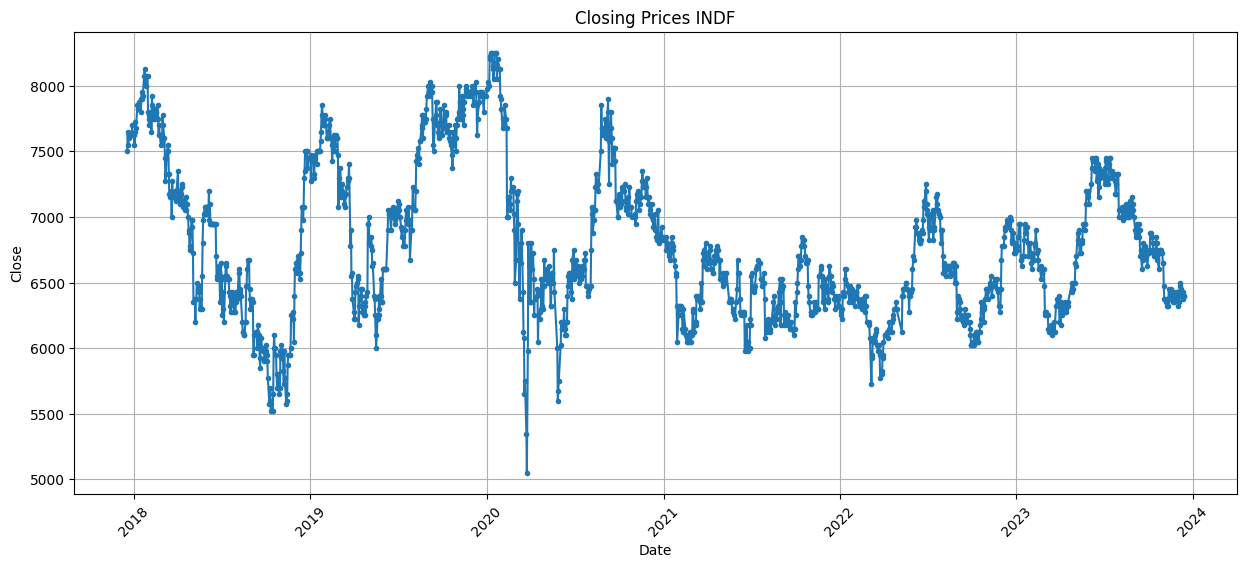

In [5]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices INDF')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

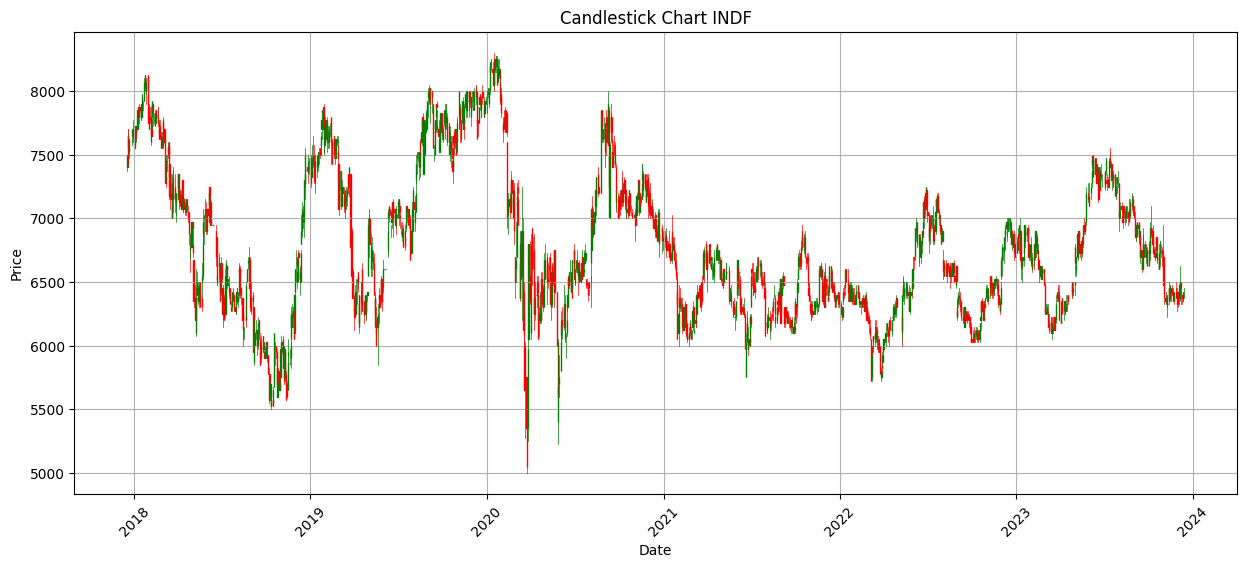

In [6]:
matplotlib_date = mdates.date2num(specific_df['Date'])

ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15,6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart INDF')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

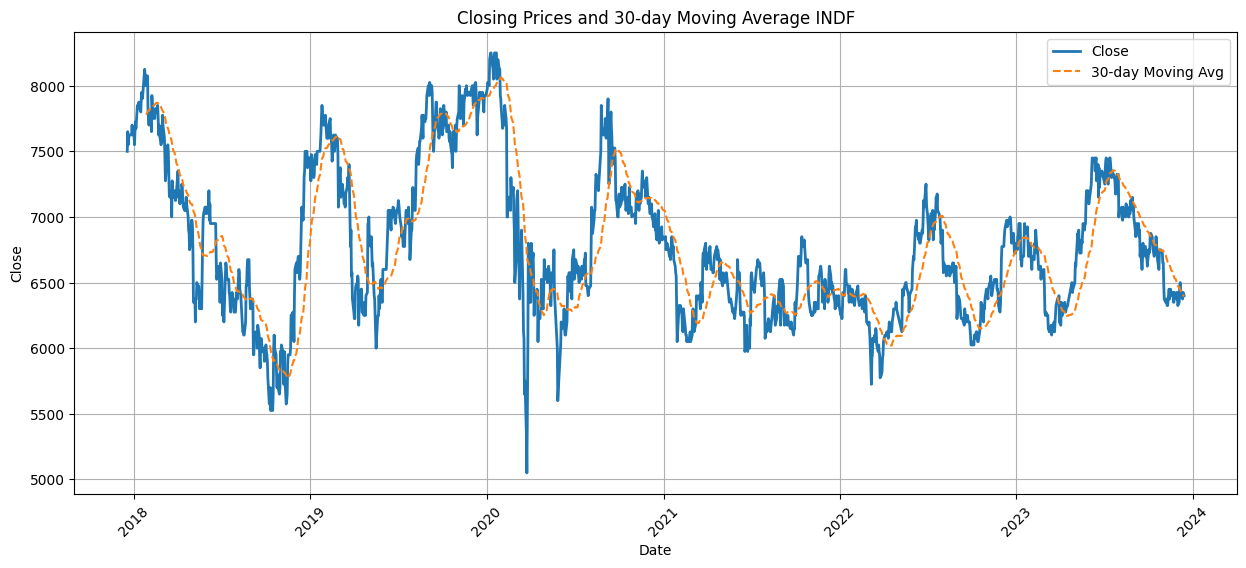

In [7]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Close', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(),label=f'{window}-day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-day Moving Average INDF')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
specific_df.head()

,Date,Close,Open,High,Low
0,2017-12-18,7500.0,7400.0,7500.0,7375.0
1,2017-12-19,7650.0,7500.0,7700.0,7475.0
2,2017-12-20,7550.0,7650.0,7700.0,7425.0
3,2017-12-21,7600.0,7525.0,7600.0,7475.0
4,2017-12-22,7625.0,7600.0,7625.0,7575.0


In [9]:
new_df = specific_df.reset_index()['Close']

In [10]:
new_df

0       7500.0
1       7650.0
2       7550.0
3       7600.0
4       7625.0
         ...  
1489    6400.0
1490    6375.0
1491    6425.0
1492    6400.0
1493    6400.0
Name: Close, Length: 1494, dtype: float64

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

Partisi Data

In [12]:
train_size = int(len(scaled_data)*0.8) #80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [13]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1135, 60)
(1135,)


Testing set size:-
(239, 60)
(239,)


(None, None)

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

LAyer = 3

dropout = 0.6

In [16]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.6))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.6))

model.add(LSTM(units=50))
model.add(Dropout(0.6))

model.add(Dense(units=1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [18]:
model.compile(loss='mean_squared_error',optimizer='adam')

epoch = 50

In [19]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=50,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/50

36/36 [==============================] - 16s 98ms/step - loss: 0.0575 - val_loss: 0.0074
Epoch 2/50
36/36 [==============================] - 2s 61ms/step - loss: 0.0256 - val_loss: 0.0046
Epoch 3/50
36/36 [==============================] - 2s 59ms/step - loss: 0.0230 - val_loss: 0.0040
Epoch 4/50
36/36 [==============================] - 2s 59ms/step - loss: 0.0200 - val_loss: 0.0031
Epoch 5/50
36/36 [==============================] - 2s 58ms/step - loss: 0.0208 - val_loss: 0.0029
Epoch 6/50
36/36 [==============================] - 2s 59ms/step - loss: 0.0189 - val_loss: 0.0025
Epoch 7/50
36/36 [==============================] - 2s 60ms/step - loss: 0.0176 - val_loss: 0.0035
Epoch 8/50
36/36 [==============================] - 2s 58ms/step - loss: 0.0164 - val_loss: 0.0023
Epoch 9/50
36/36 [==============================] - 2s 58ms/step - loss: 0.0156 - val_loss: 0.0022
Epoch 10/50
36/36 [==============================] - 2s 57ms/step - loss: 0.0150 - val_loss: 0.0022
Epoch 1

In [20]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 18ms/step


In [21]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [22]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.05908866829673317
0.0389851548632511


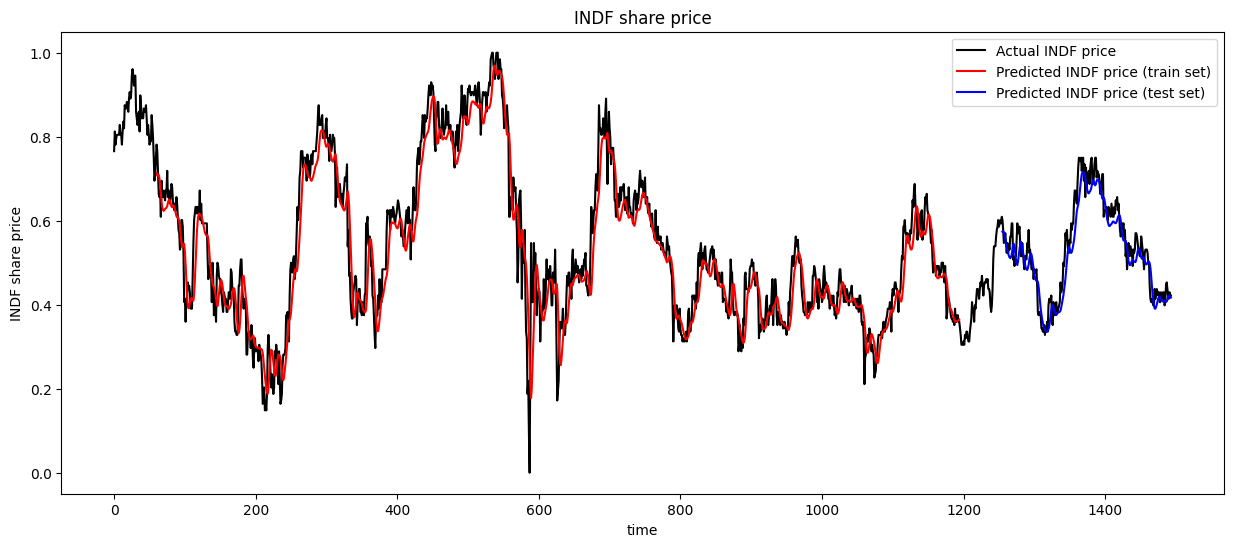

In [23]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [24]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 16ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6384.1533203125
Day 2: Predicted Price = 6374.86962890625
Day 3: Predicted Price = 6364.7119140625
Day 4: Predicted Price = 6354.3232421875
Day 5: Predicted Price = 6344.0908203125
Day 6: Predicted Price = 6334.2060546875
Day 7: Predicted Price = 6324.73974609375
Day 8: Predicted Price = 6315.7041015625
Day 9: Predicted Price = 6307.08837890625
Day 10: Predicted Price = 6298.87255859375
Day 11: Predicted Price = 6291.0361328125
Day 12: Predicted Price = 6283.56103515625
Day 13: Predicted Price = 6276.42724609375
Day 14: Predicted Price = 6269.61767578125
Day 15: Predicted Price = 6263.11474609375
Day 16: Predicted Price = 6256.90087890625
Day 17: Predicted Price = 6250.9619140625
Day 18: Predicted Price = 6245.28369140625
Day 19: Predicted Price = 6239.8515625
Day 20: Predicted Price = 6234.6552734375
Day 21: Predicted Price = 6229.68310546875
Day 22: Predicted Price = 6224.92

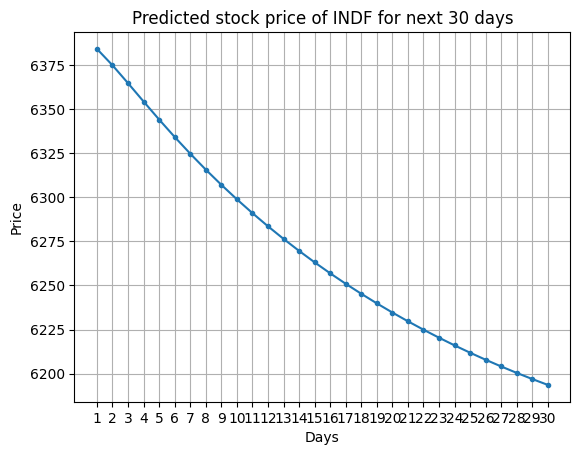

In [25]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [26]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 20ms/step - loss: 0.0015
Validation Loss: 0.001519842422567308
Validation MSE Loss: 0.001519842422567308


In [27]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.05908866829673317
Testing RMSE: 0.0389851548632511


epoch = 75

In [28]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=75,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/75
36/36 [==============================] - 2s 62ms/step - loss: 0.0054 - val_loss: 0.0013
Epoch 2/75
36/36 [==============================] - 2s 62ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 3/75
36/36 [==============================] - 2s 62ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 4/75
36/36 [==============================] - 2s 60ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 5/75
36/36 [==============================] - 2s 61ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 6/75
36/36 [==============================] - 2s 60ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 7/75
36/36 [==============================] - 2s 60ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 8/75
36/36 [==============================] - 2s 58ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 9/75
36/36 [==============================] - 2s 61ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 10/75
36/36 [==============================] - 2s 60ms/step - loss: 0.0050 - val_loss: 0.0012
Epoch 11/

In [29]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 21ms/step


In [30]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [31]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.04603650402339188
0.030394288076319585


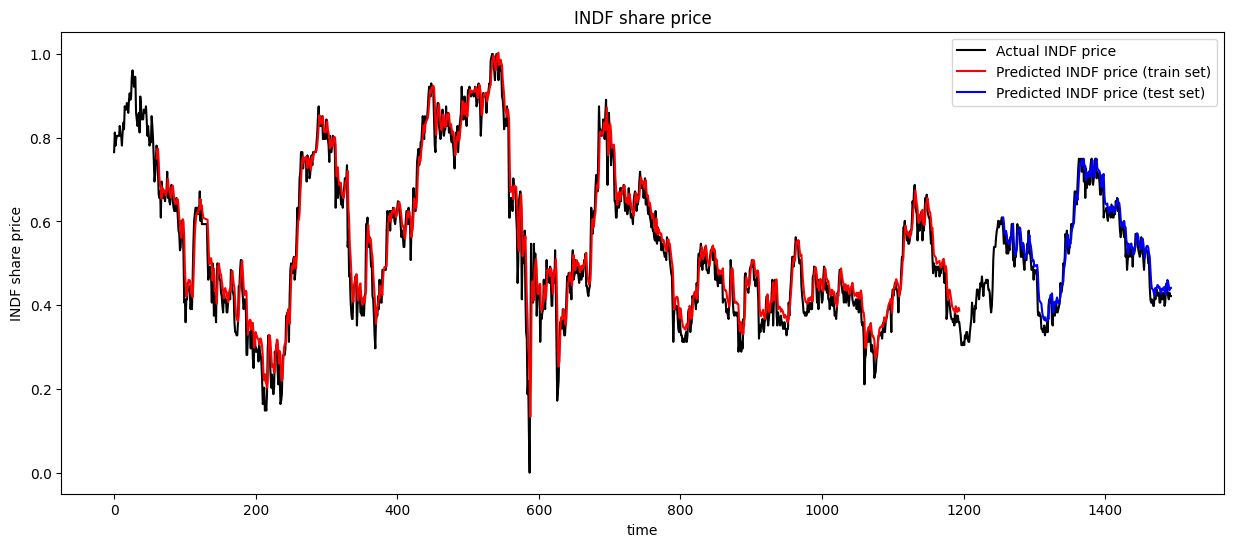

In [32]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [33]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 28ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6462.79296875
Day 2: Predicted Price = 6491.42626953125
Day 3: Predicted Price = 6520.93115234375
Day 4: Predicted Price = 6546.9931640625
Day 5: Predicted Price = 6570.26611328125
Day 6: Predicted Price = 6591.81689453125
Day 7: Predicted Price = 6612.34814453125
Day 8: Predicted Price = 6632.22900390625
Day 9: Predicted Price = 6651.6279296875
Day 10: Predicted Price = 6670.6162109375
Day 11: Predicted Price = 6689.22216796875
Day 12: Predicted Price = 6707.4599609375
Day 13: Predicted Price = 6725.33935546875
Day 14: Predicted Price = 6742.86962890625
Day 15: Predicted Price = 6760.06103515625
Day 16: Predicted Price = 6776.92333984375
Day 17: Predicted Price = 6793.46826171875
Day 18: Predicted Price = 6809.70556640625
Day 19: Predicted Price = 6825.64453125
Day 20: Predicted Price = 6841.29736328125
Day 21: Predicted Price = 6856.6708984375
Day 22: Predicted Price = 6871.

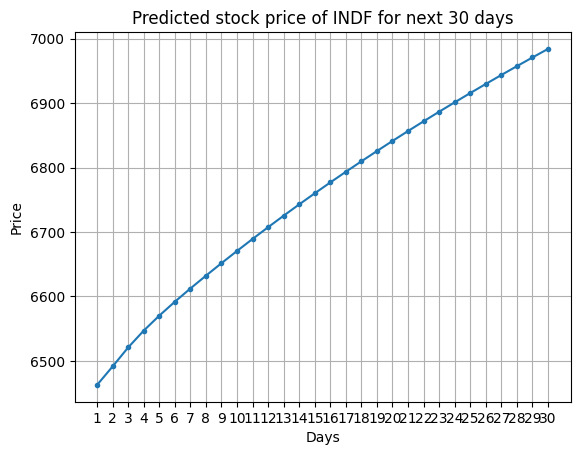

In [34]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [35]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 18ms/step - loss: 9.2381e-04
Validation Loss: 0.0009238127386197448
Validation MSE Loss: 0.0009238127386197448


In [36]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.04603650402339188
Testing RMSE: 0.030394288076319585


epoch = 100

In [37]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
36/36 [==============================] - 2s 57ms/step - loss: 0.0034 - val_loss: 9.5810e-04
Epoch 2/100
36/36 [==============================] - 2s 57ms/step - loss: 0.0037 - val_loss: 8.4185e-04
Epoch 3/100
36/36 [==============================] - 2s 47ms/step - loss: 0.0037 - val_loss: 7.8384e-04
Epoch 4/100
36/36 [==============================] - 2s 45ms/step - loss: 0.0035 - val_loss: 7.7435e-04
Epoch 5/100
36/36 [==============================] - 2s 46ms/step - loss: 0.0034 - val_loss: 8.8151e-04
Epoch 6/100
36/36 [==============================] - 2s 46ms/step - loss: 0.0036 - val_loss: 7.6075e-04
Epoch 7/100
36/36 [==============================] - 2s 51ms/step - loss: 0.0038 - val_loss: 7.2781e-04
Epoch 8/100
36/36 [==============================] - 2s 48ms/step - loss: 0.0036 - val_loss: 7.7617e-04
Epoch 9/100
36/36 [==============================] - 2s 42ms/step - loss: 0.0035 - val_loss: 7.2579e-04
Epoch 10/100
36/36 [==============================] - 2s 49ms/st

In [38]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 13ms/step


In [39]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [40]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.042239355714541946
0.02662128373433831


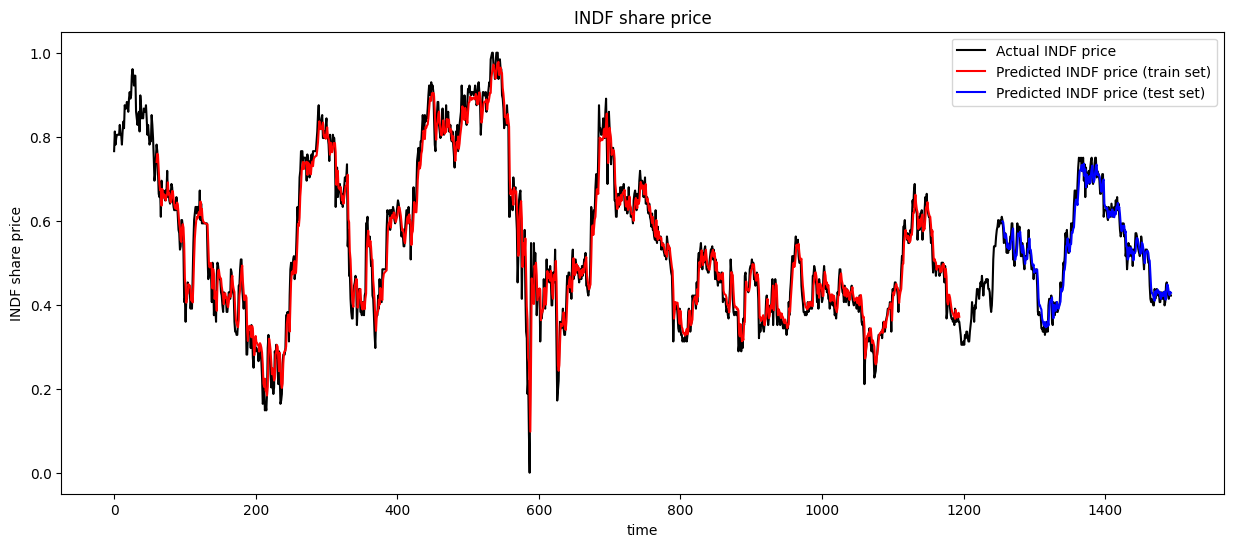

In [41]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [42]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 24ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6419.9287109375
Day 2: Predicted Price = 6428.2392578125
Day 3: Predicted Price = 6435.77490234375
Day 4: Predicted Price = 6442.25146484375
Day 5: Predicted Price = 6448.0224609375
Day 6: Predicted Price = 6453.3876953125
Day 7: Predicted Price = 6458.49609375
Day 8: Predicted Price = 6463.41943359375
Day 9: Predicted Price = 6468.19140625
Day 10: Predicted Price = 6472.83154296875
Day 11: Predicted Price = 6477.3505859375
Day 12: Predicted Price = 6481.755859375
Day 13: Predicted Price = 6486.052734375
Day 14: Predicted Price = 6490.244140625
Day 15: Predicted Price = 6494.33349609375
Day 16: Predicted Price = 6498.3212890625
Day 17: Predicted Price = 6502.20947265625
Day 18: Predicted Price = 6506.0
Day 19: Predicted Price = 6509.69384765625
Day 20: Predicted Price = 6513.2919921875
Day 21: Predicted Price = 6516.796875
Day 22: Predicted Price = 6520.21044921875
Day 23: Pre

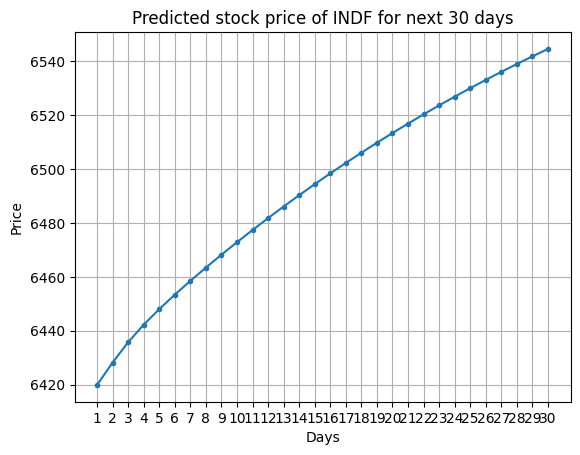

In [43]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [44]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 12ms/step - loss: 7.0869e-04
Validation Loss: 0.000708692823536694
Validation MSE Loss: 0.000708692823536694


In [45]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.042239355714541946
Testing RMSE: 0.02662128373433831


epoch = 125

In [46]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=125,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/125
36/36 [==============================] - 2s 47ms/step - loss: 0.0037 - val_loss: 8.2669e-04
Epoch 2/125
36/36 [==============================] - 2s 42ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 3/125
36/36 [==============================] - 2s 52ms/step - loss: 0.0036 - val_loss: 7.0615e-04
Epoch 4/125
36/36 [==============================] - 2s 63ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 5/125
36/36 [==============================] - 2s 49ms/step - loss: 0.0038 - val_loss: 9.8703e-04
Epoch 6/125
36/36 [==============================] - 2s 44ms/step - loss: 0.0035 - val_loss: 8.3188e-04
Epoch 7/125
36/36 [==============================] - 2s 45ms/step - loss: 0.0032 - val_loss: 7.2175e-04
Epoch 8/125
36/36 [==============================] - 2s 52ms/step - loss: 0.0034 - val_loss: 6.9817e-04
Epoch 9/125
36/36 [==============================] - 2s 44ms/step - loss: 0.0036 - val_loss: 9.0323e-04
Epoch 10/125
36/36 [==============================] - 2s 46ms/step - los

In [47]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 12ms/step


In [48]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [49]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.041449278286563945
0.026159149299173904


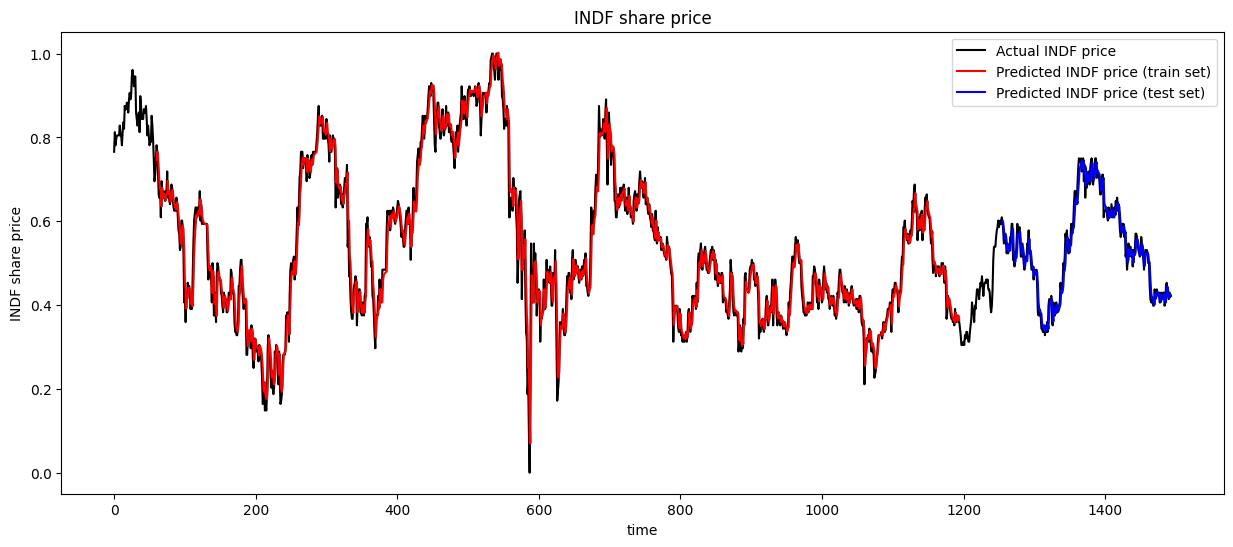

In [50]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [51]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 24ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6401.4169921875
Day 2: Predicted Price = 6398.8837890625
Day 3: Predicted Price = 6396.48193359375
Day 4: Predicted Price = 6394.1474609375
Day 5: Predicted Price = 6391.81689453125
Day 6: Predicted Price = 6389.49951171875
Day 7: Predicted Price = 6387.20263671875
Day 8: Predicted Price = 6384.9306640625
Day 9: Predicted Price = 6382.68798828125
Day 10: Predicted Price = 6380.47802734375
Day 11: Predicted Price = 6378.30517578125
Day 12: Predicted Price = 6376.1728515625
Day 13: Predicted Price = 6374.08349609375
Day 14: Predicted Price = 6372.041015625
Day 15: Predicted Price = 6370.044921875
Day 16: Predicted Price = 6368.09814453125
Day 17: Predicted Price = 6366.19970703125
Day 18: Predicted Price = 6364.35009765625
Day 19: Predicted Price = 6362.548828125
Day 20: Predicted Price = 6360.79541015625
Day 21: Predicted Price = 6359.08984375
Day 22: Predicted Price = 6357.430

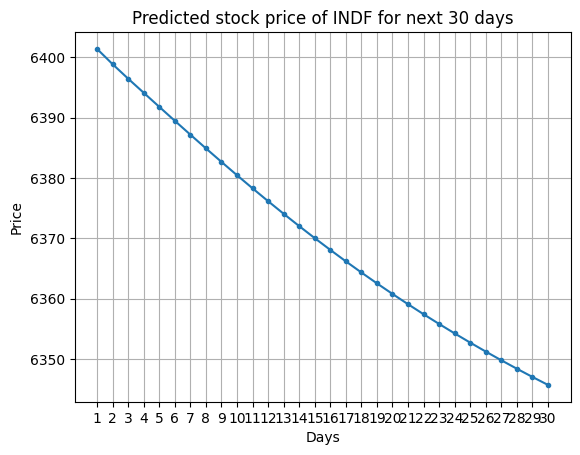

In [52]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [53]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 12ms/step - loss: 6.8430e-04
Validation Loss: 0.0006843010778538883
Validation MSE Loss: 0.0006843010778538883


In [54]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.041449278286563945
Testing RMSE: 0.026159149299173904


epoch = 150

In [55]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=150,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/150
36/36 [==============================] - 2s 49ms/step - loss: 0.0034 - val_loss: 8.8177e-04
Epoch 2/150
36/36 [==============================] - 1s 42ms/step - loss: 0.0036 - val_loss: 8.1256e-04
Epoch 3/150
36/36 [==============================] - 2s 53ms/step - loss: 0.0032 - val_loss: 7.5149e-04
Epoch 4/150
36/36 [==============================] - 2s 49ms/step - loss: 0.0036 - val_loss: 8.8611e-04
Epoch 5/150
36/36 [==============================] - 2s 47ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 6/150
36/36 [==============================] - 2s 53ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 7/150
36/36 [==============================] - 2s 45ms/step - loss: 0.0038 - val_loss: 7.8317e-04
Epoch 8/150
36/36 [==============================] - 2s 42ms/step - loss: 0.0036 - val_loss: 8.4805e-04
Epoch 9/150
36/36 [==============================] - 2s 48ms/step - loss: 0.0033 - val_loss: 7.3111e-04
Epoch 10/150
36/36 [==============================] - 2s 45ms/step - los

In [56]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 15ms/step


In [57]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [58]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.04086184009792165
0.02600196106792794


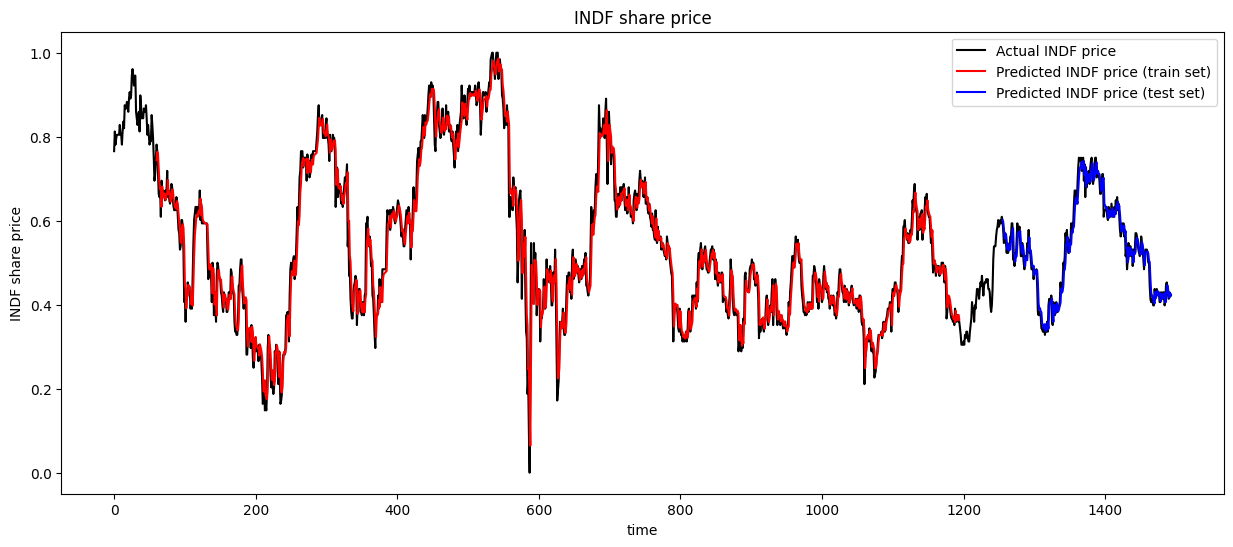

In [59]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [60]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 23ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6404.68212890625
Day 2: Predicted Price = 6404.52099609375
Day 3: Predicted Price = 6404.15185546875
Day 4: Predicted Price = 6403.736328125
Day 5: Predicted Price = 6403.17822265625
Day 6: Predicted Price = 6402.544921875
Day 7: Predicted Price = 6401.8740234375
Day 8: Predicted Price = 6401.18310546875
Day 9: Predicted Price = 6400.48583984375
Day 10: Predicted Price = 6399.78662109375
Day 11: Predicted Price = 6399.0908203125
Day 12: Predicted Price = 6398.40234375
Day 13: Predicted Price = 6397.72412109375
Day 14: Predicted Price = 6397.05908203125
Day 15: Predicted Price = 6396.40673828125
Day 16: Predicted Price = 6395.76953125
Day 17: Predicted Price = 6395.14697265625
Day 18: Predicted Price = 6394.5380859375
Day 19: Predicted Price = 6393.943359375
Day 20: Predicted Price = 6393.3623046875
Day 21: Predicted Price = 6392.7939453125
Day 22: Predicted Price = 6392.238769

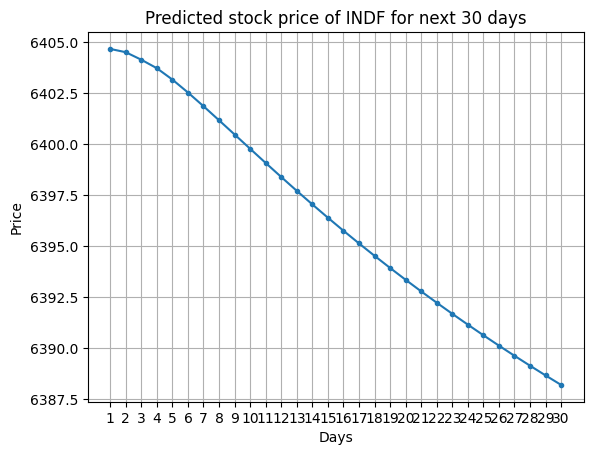

In [61]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [62]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 12ms/step - loss: 6.7610e-04
Validation Loss: 0.0006761019467376173
Validation MSE Loss: 0.0006761019467376173


In [63]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.04086184009792165
Testing RMSE: 0.02600196106792794
